<a href="https://colab.research.google.com/github/aricem/BusinessForecasting/blob/master/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preperation

Below code snippet helps us to connect Google Colab to our data in Google Drive.

In [0]:
#!pip install statsmodels==0.10.0rc2 --pre

In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

sh = gc.open('FinalProject')
worksheet = sh.worksheet("Sheet1") # By title
#worksheet = sh.sheet1 # By sheet order
#worksheet = sh.get_worksheet(0) # Select worksheet by index

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(rows)
df.columns = df.iloc[0]
df.drop(df.index[:1], inplace=True)
#Convert data types
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Aptitude'] = pd.to_numeric(df['Aptitude'], errors='coerce')
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Anxiety'] = pd.to_numeric(df['Anxiety'], errors='coerce')
df['Experience'] = pd.to_numeric(df['Experience'], errors='coerce')
df['GPA'] = pd.to_numeric(df['GPA'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 1 to 30
Data columns (total 6 columns):
Sales         30 non-null int64
Aptitude      30 non-null int64
Age           30 non-null float64
Anxiety       30 non-null float64
Experience    30 non-null int64
GPA           30 non-null float64
dtypes: float64(3), int64(3)
memory usage: 1.6 KB


## Multivariate Regression Analysis

In this study i am going to develop the best multiple regression equation to forecast whether a particular applicant will become a good salesperson. The data [Reference#1, p288] is from a pharma company. I use the first month's sales as the dependent variable ($Y$), and choose to analyze the following independent variables:

* $X_1$: selling aptitude test
* $X_2$: age, in years
* $X_3$: anxiety test score
* $X_4$: experience, in years
* $X_5$: high school GPA

These independent variables are used in the prediction of the dependent variable of **Sales**  ($Y$). The formula (*which is not the best one yet*) will be

$$ \hat{Y} = b_0 + b_1 X_1 + b_2 X_2 + b_3 X_3 + b_4 X_4 + b_5 X_5 $$


Below is the first five rows of the data frame.

In [3]:
df.head()

,Sales,Aptitude,Age,Anxiety,Experience,GPA
1,44,10,22.1,4.9,0,2.4
2,47,19,22.5,3.0,1,2.6
3,60,27,23.1,1.5,0,2.8
4,71,31,24.0,0.6,3,2.7
5,61,64,22.6,1.8,2,2.0


### Scatter plots

Scatter plots of dependent and independent variables.

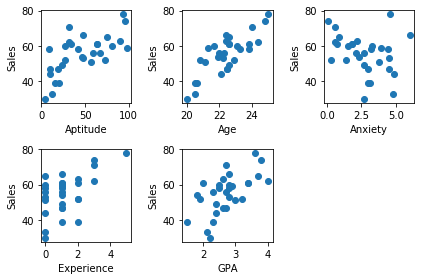

In [4]:
import matplotlib.pyplot as plt

plt.subplot(2,3,1)
plt.scatter(df.Aptitude, df.Sales)
plt.xlabel("Aptitude")
plt.ylabel("Sales")

plt.subplot(2,3,2)
plt.scatter(df.Age, df.Sales)
plt.xlabel("Age")
plt.ylabel("Sales")

plt.subplot(2,3,3)
plt.scatter(df.Anxiety, df.Sales)
plt.xlabel("Anxiety")
plt.ylabel("Sales")

plt.subplot(2,3,4)
plt.scatter(df.Experience, df.Sales)
plt.xlabel("Experience")
plt.ylabel("Sales")

plt.subplot(2,3,5)
plt.scatter(df.GPA, df.Sales)
plt.xlabel("GPA")
plt.ylabel("Sales")

plt.tight_layout()
plt.show()

### Multicollinearity

Below is the correlation matrix to check if there is multicollinearity problem. This matrix will provide essential knowledge about the basic relationships among the variables.

In [5]:
df.corr()

,Sales,Aptitude,Age,Anxiety,Experience,GPA
0,,,,,,
Sales,1.000000,0.676120,0.798141,-0.295860,0.549834,0.621784
Aptitude,0.676120,1.000000,0.227706,-0.221988,0.349639,0.317772
Age,0.798141,0.227706,1.000000,-0.286794,0.539568,0.694569
Anxiety,-0.295860,-0.221988,-0.286794,1.000000,-0.278689,-0.244382
Experience,0.549834,0.349639,0.539568,-0.278689,1.000000,0.312129
GPA,0.621784,0.317772,0.694569,-0.244382,0.312129,1.000000


In order to visualize the correlation matrix we can add some colormaps.

In [6]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'coolwarm', 'RdBu_r' and 'BrBG' are other good diverging colormaps


0,Sales,Aptitude,Age,Anxiety,Experience,GPA
0,,,,,,
Sales,1,0.67612,0.798141,-0.29586,0.549834,0.621784
Aptitude,0.67612,1,0.227706,-0.221988,0.349639,0.317772
Age,0.798141,0.227706,1,-0.286794,0.539568,0.694569
Anxiety,-0.29586,-0.221988,-0.286794,1,-0.278689,-0.244382
Experience,0.549834,0.349639,0.539568,-0.278689,1,0.312129
GPA,0.621784,0.317772,0.694569,-0.244382,0.312129,1


From the correlation matrix it can be seen that selling aptitude test, age, experience and GPA are positively related to sakes ability and have potential as good predictor variables. The anxiety test score shows a low negative correlation with sales and it is probably not an important predictor.

When we look at the correlation matrix, GPA-Age and Experience-Age are moderately correlated. It is the presence of these interrelationships that must be dealt with in attempting to find the best possible set of explanatory variables.

There are two procedures to find the best possible set of explanatory variables:

* All possible regressions
* Stepwise regression

### All Possible Regressions

Below is the analyzes of every possible combination of variables in order to select the best set of predictors.

|  Independent Variables Used |  Number of Parameters |  Error Degrees of Freedom | $R^2$ |
|-----------------------------|-----------------------|---------------------------|-------|
| None | 1 | 29 | **.0000** |
| $X_1$ | 2 | 28 | .4570 |
| $X_2$ | 2 | 28 | **.6370** |
| $X_3$ | 2 | 28 | .0880 |
| $X_4$ | 2 | 28 | .3020 |
| $X_5$ | 2 | 28 | .3870 |
| $X_1,X_2$ | 3 | 27 | **.8948** |
| $X_1,X_3$ | 3 | 27 | .4790 |
| $X_1,X_4$ | 3 | 27 | .5690 |
| $X_1,X_5$ | 3 | 27 | .6410 |
| $X_2,X_3$ | 3 | 27 | .6420 |
| $X_2,X_4$ | 3 | 27 | .6570 |
| $X_2,X_5$ | 3 | 27 | .6460 |
| $X_3,X_4$ | 3 | 27 | .3240 |
| $X_3,X_5$ | 3 | 27 | .4090 |
| $X_4,X_5$ | 3 | 27 | .5270 |
| $X_1,X_2,X_3$ | 4 | 26 | .8951 |
| $X_1,X_2,X_4$ | 4 | 26 | .8948 |
| $X_1,X_2,X_5$ | 4 | 26 | **.8953** |
| $X_2,X_3,X_4$ | 4 | 26 | .6590 |
| $X_2,X_3,X_5$ | 4 | 26 | .6500 |
| $X_2,X_4,X_5$ | 4 | 26 | .6690 |
| $X_3,X_4,X_5$ | 4 | 26 | .5310 |
| $X_1,X_2,X_3,X_4$ | 5 | 25 | .8951 |
| $X_1,X_2,X_3,X_5$ | 5 | 25 | **.8955** |
| $X_1,X_2,X_4,X_5$ | 5 | 25 | .8953 |
| $X_1,X_3,X_4,X_5$ | 5 | 25 | .7010 |
| $X_2,X_3,X_4,X_5$ | 5 | 25 | .6710 |
| $X_1,X_2,X_3,X_4,X_5$ | 6 | 24 | **.8955** |

We are going to select the best independent variable (or variables) for each parameter grouping. The equation with the highest $R^2$ is considered best.

|  Number of Parameters |  Independent Variables |  Error Degrees of Freedom | R^2 |
|-----------------------|------------------------|---------------------------|-------|
| 1 | None | 29 | .0000 |
| 2 | $X_2$ | 28 | .6370 |
| 3 | $X_1,X_2$ | 27 | .8948 |
| 4 | $X_1,X_2,X_5$ | 26 | .8953 |
| 5 | $X_1,X_2,X_3,X_5$ | 25 | .8955 |
| 6 | $X_1,X_2,X_3,X_4,X_5$ | 24 | .8955 |

The last step is to find the best and simple equation among these variables. Therefore, the highest $R^2$ possible and the simple equation possible is provided by below equation, where $X_1$ is **Aptitude** and $X_2$ is **Age**

$$ \hat{Y} = b_0 + b_1 X_1 + b_2 X_2 $$

and it explains 89.48% of the variation of $Y$.


### Stepwise Regressions

The stepwise regression procedure adds one independent variable at a time to the model, one step at a time. F-statistic is used in stepwise regression to find significance.


### Solution

By finding the best possible set of explanatory variables, we can start OLS to create model and predict coefficients.

In [7]:
import statsmodels.api as sm

X = df[['Aptitude','Age']]
Y = df['Sales']

X = sm.add_constant(X)

model = sm.OLS(Y, X, missing='drop').fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     114.8
Date:                Thu, 27 Jun 2019   Prob (F-statistic):           6.27e-14
Time:                        19:58:15   Log-Likelihood:                -80.669
No. Observations:                  30   AIC:                             167.3
Df Residuals:                      27   BIC:                             171.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -86.7915     12.353     -7.026      0.0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The model is

$$ \hat{Y} = b_0 + b_1 X_1 + b_2 X_2 $$


$$ \text{Sales} = -86.7915 + 0.1997 \text{(Aptitude)} + 5.9314 \text{(Age)} $$

The model explains 89.5% of the variation in sales.

## References

1. Business Forecasting, Eighth Edition, John E. Hanke and Dean W. Wichern. ISBN 9780131228566, Pearson International Edition


